# `make_rid_to_weather_dict.ipynb`

### Author: Anthony Hein

#### Last updated: 10/19/2021

# Overview:

Map each `rid` to an entry in the weather dataset, where we select the entry that was collected closest to the race date and time.

---

## Setup

In [154]:
from datetime import datetime, timedelta
import git
import os
from typing import List, Union
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

In [156]:
import sys

sys.path.append(f'{BASE_DIR}/utils/')

from rid_to_station_ie import RID_TO_STATION_IE

---

## Load `races_aticnmi.csv`

In [157]:
races_aticnmi = pd.read_csv(f"{BASE_DIR}/data/csv/races_aticnmi.csv", low_memory=False) 
races_aticnmi.head()

,rid,course,time,date,hurdles,prizes,winningTime,metric,countryCode,ncond,class
0,302858,Thurles (IRE),01:15,97/01/09,NaN,[],277.2,3821.0,IE,1,0
1,291347,Punchestown (IRE),03:40,97/02/16,NaN,[],447.2,5229.0,IE,5,0
2,377929,Leopardstown (IRE),03:00,97/05/11,NaN,[],106.4,1609.0,IE,4,0
3,275117,Curragh (IRE),03:35,97/05/25,NaN,[],125.9,2011.0,IE,4,0
4,66511,Leopardstown (IRE),04:30,97/06/02,NaN,[],116.3,1810.0,IE,1,0


In [158]:
races_aticnmi.shape

(19510, 11)

---

## Load `weather_all.csv`

In [159]:
weather_all = pd.read_csv(f"{BASE_DIR}/data/csv/weather_all.csv", low_memory=False) 
weather_all.head()

,date,temp,msl,rain,rhum,Station number
0,8/13/03 9:00,17.3,1023.6,0.0,72,375
1,8/13/03 10:00,18.5,1023.7,0.0,65,375
2,8/13/03 11:00,19.3,1023.7,0.0,56,375
3,8/13/03 12:00,20.4,1023.3,0.0,53,375
4,8/13/03 13:00,20.9,1023.3,0.0,54,375


In [160]:
weather_all.shape

(4162276, 6)

---

## Add UTC Instead of London TZ

A few things to note here. First, the weather data is timestamped with a UTC time but the race data is timestamped with London time. Therefore, we will make a new column w/in the race data for UTC time of the race. Secondly, the original author of the dataset did not include AM or PM on the timestamps. However, it is a strong convention that horse races occur in the afternoon, and indeed when we inspect the results, we find that this would make sense (e.g. the earliest race would be noon and the latest race would be 9:40).

In [161]:
races_aticnmi['time']

0        01:15
1        03:40
2        03:00
3        03:35
4        04:30
         ...  
19505    03:30
19506    03:30
19507    03:35
19508    03:45
19509    03:15
Name: time, Length: 19510, dtype: object

In [162]:
tms = [datetime.strptime(time + " PM", '%I:%M %p') for time in races_aticnmi['time']]

In [163]:
min(tms), max(tms)

(datetime.datetime(1900, 1, 1, 12, 0), datetime.datetime(1900, 1, 1, 21, 40))

Now that we have performed this sanity check, proceed with the conversion.

In [164]:
races_aticnmi['time utc'] = [
    datetime.strptime(
        ('0' + row['date'].rstrip(' 00:00') if row['date'][1] == '/' else row['date'].rstrip(' 00:00')) + \
        ' ' + row['time'] + ' PM', '%y/%m/%d %I:%M %p'
    )
    for idx, row
    in races_aticnmi.iterrows()
]

In [165]:
races_aticnmi.head()

,rid,course,time,date,hurdles,prizes,winningTime,metric,countryCode,ncond,class,time utc
0,302858,Thurles (IRE),01:15,97/01/09,NaN,[],277.2,3821.0,IE,1,0,1997-01-09 13:15:00
1,291347,Punchestown (IRE),03:40,97/02/16,NaN,[],447.2,5229.0,IE,5,0,1997-02-16 15:40:00
2,377929,Leopardstown (IRE),03:00,97/05/11,NaN,[],106.4,1609.0,IE,4,0,1997-05-11 15:00:00
3,275117,Curragh (IRE),03:35,97/05/25,NaN,[],125.9,2011.0,IE,4,0,1997-05-25 15:35:00
4,66511,Leopardstown (IRE),04:30,97/06/02,NaN,[],116.3,1810.0,IE,1,0,1997-06-02 16:30:00


---

## Make Helper Function for Finding Nearest Weather Reading

Here, we take advantage of the fact that the entries for a given station number are in time order.

In [166]:
weather_all[weather_all['Station number'] == 275]

,date,temp,msl,rain,rhum,Station number
2155805,8/14/03 1:00,10.9,1024.2,0.0,87,275
2155806,8/14/03 2:00,10.7,1024.0,0.0,86,275
2155807,8/14/03 3:00,10.2,1024.0,0.0,86,275
2155808,8/14/03 4:00,9.5,1023.8,0.0,90,275
2155809,8/14/03 5:00,9.2,1023.7,0.0,92,275
...,...,...,...,...,...,...
2306555,12/31/20 19:00,6.4,1014.6,0.0,79,275
2306556,12/31/20 20:00,6.1,1015.9,0.0,79,275
2306557,12/31/20 21:00,6.2,1016.1,0.0,76,275
2306558,12/31/20 22:00,6.0,1016.6,0.0,80,275


In [167]:
def nearest_weather_reading(rid: int, time: datetime):
    """
    Return index of the nearest weather reading and its distance from the query time.
    """
    
    # we already know what station we are looking for
    weather_at_station = weather_all[weather_all['Station number'] == RID_TO_STATION_IE[rid][0]]
    
    # binary search through the list
    # https://stackoverflow.com/questions/23681948/get-index-of-closest-value-with-binary-search
    
    lo = 0
    hi = len(weather_at_station) - 1
    
    best_ind = lo
    best_entry_time = datetime.strptime(weather_at_station.iloc[lo]['date'], '%m/%d/%y %H:%M')
    
    while lo <= hi:
        
        mid = lo + (hi - lo) // 2
        
        entry_time = datetime.strptime(weather_at_station.iloc[mid]['date'], '%m/%d/%y %H:%M')
        
        if entry_time < time:
            lo = mid + 1
            
        elif entry_time > time:
            hi = mid - 1
            
        else:
            best_ind = mid
            best_entry_time = datetime.strptime(weather_at_station.iloc[best_ind]['date'], '%m/%d/%y %H:%M')
            break
    
        if abs(entry_time - time) < abs(best_entry_time - time):
            best_ind = mid
            best_entry_time = datetime.strptime(weather_at_station.iloc[best_ind]['date'], '%m/%d/%y %H:%M')

    return weather_at_station.iloc[best_ind].name, abs(best_entry_time - time)

In [168]:
nearest_weather_reading(302858, races_aticnmi.iloc[0]['time utc'])

(1116215, Timedelta('0 days 00:15:00'))

In [169]:
races_aticnmi[races_aticnmi['rid'] == 302858]

,rid,course,time,date,hurdles,prizes,winningTime,metric,countryCode,ncond,class,time utc
0,302858,Thurles (IRE),01:15,97/01/09,NaN,[],277.2,3821.0,IE,1,0,1997-01-09 13:15:00


In [170]:
weather_all.loc[1072295].to_dict()

{'date': '1/12/90 17:00',
 'temp': 3.6,
 'msl': 1021.5,
 'rain': 0.2,
 'rhum': 90,
 'Station number': 4919}

---

## Make `rid` to Weather Dict (w/ "goodness" measure)

In [171]:
d = {}

for _, row in tqdm(races_aticnmi.iterrows()): 
    idx, goodness = nearest_weather_reading(row['rid'], row['time utc'])
    weather = weather_all.loc[idx].to_dict()
    d[row['rid']] = (weather, goodness)

19510it [05:35, 58.07it/s]


In [172]:
smpl = races_aticnmi.sample(10)

In [173]:
[(rid, d[rid]) for rid in smpl['rid']]

[(272669,
  ({'date': '4/5/12 19:00',
    'temp': 7.1,
    'msl': 1022.9,
    'rain': 0.0,
    'rhum': 55,
    'Station number': 575},
   Timedelta('0 days 00:25:00'))),
 (119163,
  ({'date': '5/29/18 20:00',
    'temp': 21.1,
    'msl': 1016.8,
    'rain': 0.0,
    'rhum': 62,
    'Station number': 1175},
   Timedelta('0 days 00:30:00'))),
 (123535,
  ({'date': '8/1/16 16:00',
    'temp': 15.6,
    'msl': 1010.8,
    'rain': 0.0,
    'rhum': 88,
    'Station number': 1375},
   Timedelta('0 days 00:25:00'))),
 (183241,
  ({'date': '5/4/08 15:00',
    'temp': 17.0,
    'msl': 1017.9,
    'rain': 0.0,
    'rhum': 57,
    'Station number': 375},
   Timedelta('0 days 00:25:00'))),
 (409518,
  ({'date': '8/31/20 17:00',
    'temp': 15.7,
    'msl': 1016.0,
    'rain': 0.0,
    'rhum': 66,
    'Station number': 4935},
   Timedelta('0 days 00:30:00'))),
 (138802,
  ({'date': '8/18/16 18:00',
    'temp': 14.8,
    'msl': 1005.0,
    'rain': 0.0,
    'rhum': 75,
    'Station number': 2275},
   

---

## Determine Goodness of Values

There may be small inconsistencies in the weather datasets or null values such that we don't actually have the data for a date that a race occurs. The above algorithm _will not fail_, it will still return the closest entry, but this may not be good enough. We are wondering if there is enough data such that we can just drop these, rather than manually correcting this, which would be intractable.

In [186]:
def get_days_from_goodness(goodness):
    return int(str(goodness)[:str(goodness).find(" days")])

In [187]:
goodness_days = [get_days_from_goodness(v[1]) for k,v in d.items()]
goodness_days[:5]

[0, 0, 0, 0, 0]

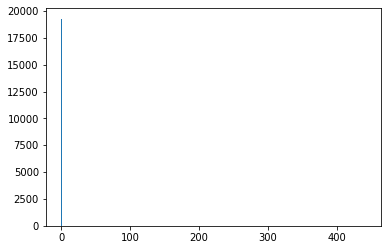

In [188]:
binwidth = 1
bins=np.arange(min(goodness_days), max(goodness_days) + binwidth, binwidth)

plt.hist(goodness_days, bins=bins)
plt.show()

In [189]:
pd.Series(goodness_days).value_counts()

0      19293
9         13
6         13
10        12
3         10
       ...  
213        1
148        1
160        1
97         1
7          1
Length: 67, dtype: int64

Instead of going at the granularity of days, we can be as specific as the seconds.

In [195]:
goodness_days = [v[1].total_seconds() for k,v in d.items()]
goodness_days[:5]

[900.0, 1200.0, 0.0, 1500.0, 1800.0]

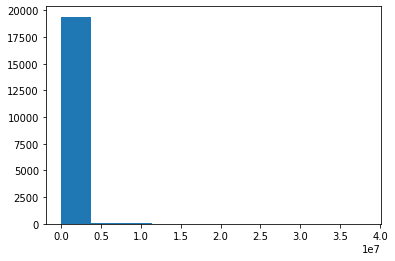

In [197]:
plt.hist(goodness_days)
plt.show()

In [202]:
sum(np.array(goodness_days) <= 30 * 60)

19271

In [201]:
np.mean(np.array(goodness_days) <= 30 * 60)

0.9877498718605843

Indeed, a large proportion of the dataset is unaffected by this; 98.7% of the data is accurate to a half-hour which we expect since the data is hourly so a race should be at most a half-hour off from the last-measured time. So we can simply drop those entries which are not within a half-hour

In [204]:
d = {k:v[0] for k,v in d.items() if v[1].total_seconds() <= 30 * 60}

In [205]:
len(d)

19271

---

## Write to File in `utils`

In [206]:
s = f"RID_TO_WEATHER = {d}"
s[:100]

"RID_TO_WEATHER = {302858: {'date': '1/9/97 13:00', 'temp': 2.2, 'msl': 1012.7, 'rain': 0.0, 'rhum': "

In [207]:
with open(f"{BASE_DIR}/utils/rid_to_weather.py", 'w', encoding='utf-8') as f:
    f.write(s)

---